In [2]:
# Welcome to your new notebook
# Type here in the cell editor to add code!
%pip install torch

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 9, Finished, Available)


[notice] A new release of pip is available: 23.0 -> 23.2
[notice] To update, run: /nfs4/pyenv-98b8aa98-b6fc-413b-a5db-820fb80e5ba3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torchvision

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, -1, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 106.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 90.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 53.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 146.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 56.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 17.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 50.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 168.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
train_df = spark.sql("SELECT * FROM DemoLakehouse.sampled_train LIMIT 1000")

import pandas as pd

# convert train_df to pandas dataframe
train_df = train_df.toPandas()

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 17, Finished, Available)

In [5]:
# Create a new column in the dataframe to apply to the filename column tor read the image URL
train_df['image_url'] = train_df['filename'].apply(lambda filename: f"/lakehouse/default/Files/images/train/{filename}")

train_df.head()

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 18, Finished, Available)

,filename,label,image_url
0,S7/P13/P13_R1/S7_P13_R1_IMAG1518.JPG,elephant,/lakehouse/default/Files/images/train/S7/P13/P...
1,S7/O10/O10_R2/S7_O10_R2_IMAG1454.JPG,gazellegrants,/lakehouse/default/Files/images/train/S7/O10/O...
2,S2/H07/H07_R2/S2_H07_R2_PICT2795.JPG,guineafowl,/lakehouse/default/Files/images/train/S2/H07/H...
3,S5/H07/H07_R1/S5_H07_R1_IMAG4660.JPG,guineafowl,/lakehouse/default/Files/images/train/S5/H07/H...
4,S2/H07/H07_R1/S2_H07_R1_PICT0539.JPG,hartebeest,/lakehouse/default/Files/images/train/S2/H07/H...


In [6]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the LabelEncoder to the label column in the train_df DataFrame
le.fit(train_df['label'])

# Transform the label column to numerical labels using the LabelEncoder
train_df['labels'] = le.transform(train_df['label'])

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 19, Finished, Available)

In [7]:
# Repeat the process for the test dataset
test_df = spark.sql("SELECT * FROM DemoLakehouse.sampled_test LIMIT 1000")

# convert test_df to pandas dataframe
test_df = test_df.toPandas()

# Create a new column in the dataframe using the apply method
test_df['image_url'] = test_df['filename'].apply(lambda filename: f"/lakehouse/default/Files/images/train/{filename}")

# Fit the LabelEncoder to the label column in the test_df DataFrame
le.fit(test_df['label'])

# Transform the label column to numerical labels using the LabelEncoder
test_df['labels'] = le.transform(test_df['label'])

# combine both the train and test dataset
data = pd.concat([test_df, train_df])

# drop filename column 
data = data[['image_url', 'labels']]

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 20, Finished, Available)

In [9]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import os
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        while True:
            img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
            if not os.path.exists(img_name):
                idx = (idx + 1) % len(self.data)
                continue
            image = Image.open(img_name)
            if self.transform:
                image = self.transform(image)
            labels = self.data.iloc[idx, 1]
            return image, labels

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = CustomDataset("/lakehouse/default/Files/images/train/", transform=transform)
test_set = CustomDataset("/lakehouse/default/Files/images/test/", transform=transform)

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 22, Finished, Available)

In [10]:
# Load the training and test data
train_loader = DataLoader(train_set, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 23, Finished, Available)

In [11]:
# Using mlflow library to activate our ml experiment

import mlflow

mlflow.set_experiment("serengeti-experiment")

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 24, Finished, Available)

2023/07/19 15:42:33 INFO mlflow.tracking.fluent: Experiment with name 'serengeti-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='', creation_time=1689781358654, experiment_id='d3f9753b-ab56-493b-b75b-720a467bc6c5', last_update_time=None, lifecycle_stage='active', name='serengeti-experiment', tags={}>

In [14]:
import torch
import torchvision
import torch.nn as nn

# load the pre-trained DenseNet 201 model
model = torchvision.models.densenet201(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 53)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 27, Finished, Available)

In [16]:
# define the loss function
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 29, Finished, Available)

In [17]:
# train the model
num_epochs = 5
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ["train", "val"]:
        if phase == "train":
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(train_loader, ):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == "train":
                    loss.backward()
                    optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 20:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        
    print('Finished Training')

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 30, Finished, Available)

Epoch 0/4
----------
Finished Training
Epoch 1/4
----------
Finished Training
Epoch 2/4
----------
Finished Training
Epoch 3/4
----------
Finished Training
Epoch 4/4
----------
Finished Training


In [18]:
# use an MLflow run and track the results within our machine learning experiment.

with mlflow.start_run() as run:
    print("log pytorch model:")
    mlflow.pytorch.log_model(
        model, "pytorch-model",
        registered_model_name="serengeti-pytorch"
    )
    
    model_uri = "runs:/{}/pytorch-model".format(run.info.run_id)
    print("Model saved in run %s" % run.info.run_id)
    print(f"Model URI: {model_uri}")

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 31, Finished, Available)

log pytorch model:
Model saved in run fa021ff1-28bd-421a-bba9-7012a210226a
Model URI: runs:/fa021ff1-28bd-421a-bba9-7012a210226a/pytorch-model


2023/07/19 15:53:51 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp5cq_lt5t/model/data, flavor: pytorch), fall back to return ['torch==2.0.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'serengeti-pytorch'.
2023/07/19 15:53:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: serengeti-pytorch, version 1
Created version '1' of model 'serengeti-pytorch'.


In [19]:
# load and evaluate the model
loaded_model = mlflow.pytorch.load_model(model_uri)
print(type(loaded_model))
correct_cnt, total_cnt, ave_loss = 0, 0, 0
for batch_idx, (x, target) in enumerate(test_loader):
    x, target = x, target
    out = loaded_model(x)
    loss = criterion(out, target)
    _, pred_label = torch.max(out.data, 1)
    total_cnt += x.data.size()[0]
    correct_cnt += (pred_label == target.data).sum()
    ave_loss = (ave_loss * batch_idx + loss.item()) / (batch_idx + 1)
    
    if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(test_loader):
        print(
            "==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}".format(
                epoch, batch_idx + 1, ave_loss, correct_cnt * 1.0 / total_cnt
            )
        )

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 32, Finished, Available)

<class 'torchvision.models.densenet.DenseNet'>
==>>> epoch: 4, batch index: 5, test loss: 31494.506250, acc: 0.373


StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 34, Finished, Available)

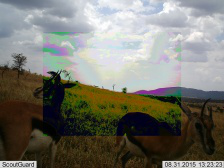

In [21]:
# Load a new image from the test data using Pillow
image = Image.open('/lakehouse/default/Files/images/test/SER_S11/B03/B03_R1/SER_S11_B03_R1_IMAG1021.JPG')
image

In [22]:
# Resize the image to a fixed size
resize_transform = transforms.Resize((224, 224))
image = resize_transform(image)

# Convert the image to a PyTorch tensor
tensor_transform = transforms.ToTensor()
tensor = tensor_transform(image)

# Add a batch dimension to the tensor
tensor = tensor.unsqueeze(0)

# Load the model from MLflow
model = mlflow.pytorch.load_model(model_uri)

# Set the model to evaluation mode
model.eval()

# Pass the tensor through the model to get the output
with torch.no_grad():
    output = model(tensor)

# Get the predicted class
_, predicted = torch.max(output.data, 1)

print(predicted.item())

StatementMeta(, 2511b538-6adf-43c2-8c1f-705b65a98530, 35, Finished, Available)

7
